In [1]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import numpy as np
import os

In [ ]:

def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    print(end_date)
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    print(df['time_bin'].dtype)
    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 
    grid_crime_df['x_index'] = grid_crime_df['x_index'].astype('int64') 
    grid_crime_df['y_index'] = grid_crime_df['y_index'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D') # doesn't allow for custom bins
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)
    grid_crime_df['day_of_week'] = grid_crime_df['occ_date'].dt.dayofweek

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'x_index', 'y_index', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences



def calculate_neighbourhood_crime_counts(data, radius=10):
  
    # Ensure data is sorted for efficient processing
    data = data.sort_values(by="time_bin")

    # Prepare results
    results = []

    # Process each time_bin
    for time_bin, group in data.groupby("time_bin"):
        group_results = []
        
        # Convert group to a dictionary for efficient lookup
        crime_lookup = {(row.x_index, row.y_index): row.crime_count for row in group.itertuples()}
        
        # Iterate through each cell
        for _, row in group.iterrows():
            x, y = row["x_index"], row["y_index"]
            
            # Neighborhood bounds
            x_min, x_max = x - radius, x + radius
            y_min, y_max = y - radius, y + radius
            
            # Calculate total crimes in the neighborhood
            total_neighborhood_crime = sum(
                crime_lookup.get((i, j), 0)
                for i in range(x_min, x_max + 1)
                for j in range(y_min, y_max + 1)
            )
            
            # Append result for this cell
            group_results.append({
                "unique_id": row["unique_id"],
                "time_bin": row["time_bin"],
                "neighbourhood_crime_count": total_neighborhood_crime,
            })
        
        # Extend results
        results.extend(group_results)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge results back to the original data
    data = data.merge(results_df, on=["unique_id", "time_bin"])
    
    return data



In [114]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")
cell_size = 600
aggregation_period = 14 # In days

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)
hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)


sequence_length = 26 # looking over whole year data to capture seasonal trend


2017-03-14 00:00:00
datetime64[ns]
2017-06-14 00:00:00
datetime64[ns]
5.0


/tmp/ipykernel_172663/4273057723.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_172663/4273057723.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [116]:

last_time_bin = train_hotspots_crime_counts_df.time_bin.max()
start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])

#Ensuring all the same cells in both train and test data
# np.all(hotspot_cells == np.sort(test_hotspots_crime_counts_df.unique_id.unique()) )

test_hotspots_crime_counts_df.unique_id.unique().size
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,hotspot
839,1290,33,96,2016-03-10,1,0
840,1290,33,96,2016-03-24,2,0
841,1290,33,96,2016-04-07,1,0
842,1290,33,96,2016-04-21,2,0
843,1290,33,96,2016-05-05,2,0
...,...,...,...,...,...,...
6353,11781,148,34,2017-05-24,1,0
6369,11822,149,34,2017-03-29,1,0
6370,11822,149,34,2017-04-12,2,0
6371,11822,149,34,2017-04-26,3,0


In [117]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_current = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bins_history.append(test_time_bins_current)

In [144]:

all_train_cells = train_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()
all_test_cells = test_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()

# all_train_cells_dict  = train_crime_counts_df.set_index(['unique_id', 'x_index', 'y_index']).T.to_dict() # just a bit faster
# train_time_bins_df = pd.DataFrame([(unique_id, x_index, y_index, time_bin) for unique_id, x_index, y_index in all_train_cells_dict for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# train_time_bins_df
train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
test_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in test_time_bins.sort_values()],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])

# # train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for index, row in train_crime_counts_df.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# # test_time_bins_df = pd.DataFrame([(unique_id, time_bin) for unique_id in all_test_cells for time_bin in test_time_bins],columns=['unique_id', 'time_bin'])

# train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
# # test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df, on=[ 'unique_id'], how='left').fillna(0)

# # # test_crime_counts_df_with_all_time_bins = 


In [146]:
train_hotspots_crime_counts_df[train_hotspots_crime_counts_df['unique_id'].isin(hotspot_cells)].unique_id.unique().size

351

In [147]:
test_time_bins_df[test_time_bins_df.unique_id.isin(hotspot_cells)].unique_id.unique().size
# hotspot_cells

351

In [149]:
train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
train_crime_counts_df_with_all_time_bins['crime_count'].max()
test_crime_counts_df_with_all_time_bins['crime_count'].max()

16.0

In [153]:

# train_hotspots_crime_counts_df["neighbourhood_crime_counts"] = train_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(train_crime_counts_df_with_all_time_bins, 1 )
# )

train_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts(train_crime_counts_df_with_all_time_bins, radius=5)
test_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts(test_crime_counts_df_with_all_time_bins, radius=5)
# x = calculate_neighbourhood_crime_counts(train_hotspots_crime_counts_df, radius=1)

# test_hotspots_crime_counts_df["neighbourhood_crime_counts"] = test_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(test_crime_counts_df_with_all_time_bins, 10 )
# )



In [159]:
train_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
train_hotspots_crime_counts_df.loc[train_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
test_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
test_hotspots_crime_counts_df.loc[test_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
train_hotspots_crime_counts_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]

In [160]:
test_hotspots_crime_counts_df
train_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
23,8666,108,51,2012-03-01,2.0,19.0,0
50,6615,83,38,2012-03-01,0.0,17.0,0
53,8668,108,53,2012-03-01,2.0,19.0,0
76,2453,44,94,2012-03-01,0.0,23.0,0
140,4802,65,46,2012-03-01,0.0,33.0,0
...,...,...,...,...,...,...,...
913353,10310,128,39,2017-02-23,0.0,19.0,0
913368,3187,51,21,2017-02-23,0.0,5.0,0
913414,11197,139,52,2017-02-23,0.0,12.0,0
913431,10311,128,40,2017-02-23,0.0,19.0,0


In [161]:
# np.all(hotspot_cells == train_hotspots_crime_counts_df.unique_id.unique())
# np.intersect1d( test_hotspots_crime_counts_df.unique_id.unique(), hotspot_cells).size
hotspot_cells.size

train_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates',str(cell_size),  f'train_hotspots_crime_counts_df_{threshold}_{sequence_length}.csv'))
test_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates', str(cell_size), f'test_hotspots_crime_counts_df_{threshold}_{sequence_length}.csv'))


In [20]:
# train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
# test_time_bins = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
#  = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
# train_time_bins = pd.date_range(start=train['time_bin'].min(), 
#                           end=crime_counts['time_bin'].max(), freq='14D')
# tensor = pd.DataFrame([(grid, time) for grid in hotspot_cells for time_bin in time_bins],columns=['unique_id', 'time_bin'])
train_crime_counts_df.crime_count.max()

20

In [180]:

test_hotspots_crime_counts_df
train_hotspots_crime_counts_df = train_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1775,1290,33,96,2016-03-10,0.0,0.0,0
13321,1290,33,96,2016-03-24,0.0,0.0,0
14769,1290,33,96,2016-04-07,0.0,0.0,0
25480,1290,33,96,2016-04-21,0.0,0.0,0
30441,1290,33,96,2016-05-05,0.0,0.0,0
...,...,...,...,...,...,...,...
196301,11822,149,34,2017-03-29,1.0,18.0,0
207940,11822,149,34,2017-04-12,2.0,15.0,0
210688,11822,149,34,2017-04-26,3.0,14.0,0
217164,11822,149,34,2017-05-10,0.0,16.0,0


In [ ]:
# train_hotspots_crime_counts_df = grid_time_bin_train_df.merge(train_hotspots_crime_counts_df, on=['unique_id', 'time_bin', 'x_index', 'y_index'], how='left').fillna(0)
# test_hotspots_crime_counts_df = grid_time_bin_test_df.merge(test_hotspots_crime_counts_df, on=['unique_id', 'time_bin','x_index', 'y_index'], how='left').fillna(0)
# train_hotspots_crime_counts_df.time_bin.max()
# test_hotspots_crime_counts_df[test_hotspots_crime_counts_df['crime_count'] > 5]


,unique_id,x_index,y_index,time_bin,crime_count,hotspot
21,1290,33,96,2016-12-29,10.0,1.0
177,1522,36,95,2016-08-25,6.0,1.0
735,3261,51,95,2016-07-14,6.0,1.0
825,4013,58,55,2016-03-10,6.0,1.0
838,4013,58,55,2016-09-08,6.0,1.0
...,...,...,...,...,...,...
11337,11517,143,50,2016-11-17,6.0,1.0
11346,11517,143,50,2017-03-15,10.0,1.0
11347,11517,143,50,2017-03-29,6.0,1.0
11349,11517,143,50,2017-04-26,14.0,1.0


In [162]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

In [182]:
test_hotspots_crime_counts_df
train_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
1576,1290,33,96,2012-03-01,1.0,27.0,0
9636,1290,33,96,2012-03-15,0.0,17.0,0
15322,1290,33,96,2012-03-29,1.0,11.0,0
27226,1290,33,96,2012-04-12,0.0,17.0,0
33326,1290,33,96,2012-04-26,0.0,16.0,0
...,...,...,...,...,...,...,...
879437,11822,149,34,2016-12-29,3.0,11.0,0
890132,11822,149,34,2017-01-12,2.0,11.0,0
896849,11822,149,34,2017-01-26,2.0,18.0,0
901418,11822,149,34,2017-02-09,0.0,8.0,0


In [183]:
training_sequences = create_sequences(train_hotspots_crime_counts_df, seq_length=sequence_length)


In [186]:
training_sequences[-1]

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
725450,11822,149,34,2016-02-25,0.0,8.0,0
733331,11822,149,34,2016-03-10,0.0,7.0,0
743548,11822,149,34,2016-03-24,0.0,8.0,0
750834,11822,149,34,2016-04-07,0.0,12.0,0
759313,11822,149,34,2016-04-21,0.0,13.0,0
765465,11822,149,34,2016-05-05,3.0,19.0,0
773309,11822,149,34,2016-05-19,0.0,11.0,0
774444,11822,149,34,2016-06-02,1.0,16.0,0
784793,11822,149,34,2016-06-16,0.0,7.0,0
791832,11822,149,34,2016-06-30,0.0,14.0,0


In [187]:
testing_sequences = create_sequences(test_hotspots_crime_counts_df, seq_length=sequence_length)

In [188]:
testing_sequences[-1]

,unique_id,x_index,y_index,time_bin,crime_count,neighbourhood_crime_count,hotspot
44642,11822,149,34,2016-06-02,0.0,0.0,0
54446,11822,149,34,2016-06-16,0.0,0.0,0
61810,11822,149,34,2016-06-30,0.0,0.0,0
63984,11822,149,34,2016-07-14,0.0,0.0,0
71811,11822,149,34,2016-07-28,0.0,0.0,0
82002,11822,149,34,2016-08-11,0.0,0.0,0
87384,11822,149,34,2016-08-25,0.0,0.0,0
93072,11822,149,34,2016-09-08,0.0,0.0,0
101993,11822,149,34,2016-09-22,0.0,0.0,0
105859,11822,149,34,2016-10-06,0.0,0.0,0


In [189]:
from sklearn.utils import resample

positive_data = []
negative_data = []
for sequence in training_sequences:
    if sequence['hotspot'].iloc[-1] == 1:
        positive_data.append(sequence)
    else:
        negative_data.append(sequence)

print(len(positive_data))
negative_data = resample(negative_data, replace=False,  n_samples=len(positive_data), random_state=1) 

# Combine positive and negative data
balanced_data = positive_data + negative_data

from sklearn.model_selection import train_test_split


# Split into training and remaining sets
train_data, val_data = train_test_split(balanced_data, test_size=0.1, random_state=1)

test_data = testing_sequences
# # Split the remaining set into validation and test sets
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=1)

2248


In [197]:
import numpy as np

# Assuming 'train_samples', 'val_samples', and 'test_samples' are the lists of samples

def prepare_trainable_data(samples):
    X = []
    y = []
    for seq in samples:
        X_seq = seq[['crime_count', 'neighbourhood_crime_count']].values  # Select features for X
        X.append(X_seq[:-1])  # Exclude the last time step from X
        y.append(seq['hotspot'].iloc[-1])  # Use the last time step's 'hotspot' value as y
    # return X, y
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_trainable_data(train_data)

# Prepare validation data
X_val, y_val = prepare_trainable_data(val_data)

# Prepare test data
X_test, y_test = prepare_trainable_data(test_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((4046, 26, 2), (2457, 26, 2), (4046,), (2457,))

In [191]:
X_train.shape, X_test.shape
np.save('a.npy',X_train,)

In [383]:
# ## Grid Search

# # import os
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# import numpy as np
# from sklearn.model_selection import GridSearchCV
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Assuming X_train, y_train, X_val, y_val have been created

# # Define the LSTM model
# def create_model(units_layer1=50,units_layer2=50, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units=units_layer1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=units_layer2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
#     return model

# # Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model, metrics=['accuracy'],verbose=0)

# # Define the hyperparameter grid
# # param_grid = {
# #     'model__units': [20, 50, 80],
# #     'model__learning_rate': [0.01, 0.001, 0.0001],
# #     'batch_size': [16, 32, 64],
# #     'epochs': [20, 30, 40]
# # }

# param_grid = {
#     'model__units': [20,50,80],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32, 64],
#     'epochs': [20, 50]
# }
# param_grid = {
#     'model__units_layer1': [50,100],
#     'model__units_layer2': [25,50],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32],
#     'epochs': [50]
# }

# model = KerasClassifier(model=create_model, optimizer='adam', verbose=0)

# # Fit and predict
# # model.fit(X_train, y_train)
# # predictions = model.predict(X_test)


# # # Create a GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')  # 3-fold cross-validation

# # Fit the grid search to the data
# grid_result = grid.fit(X_train, y_train)

# # Print the best hyperparameters
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=20)),
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate= 0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [208]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5389 - loss: 0.7013 - val_accuracy: 0.6689 - val_loss: 0.6457
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7014 - loss: 0.6108 - val_accuracy: 0.7089 - val_loss: 0.5611
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7478 - loss: 0.5339 - val_accuracy: 0.8067 - val_loss: 0.4931
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8014 - loss: 0.4672 - val_accuracy: 0.8200 - val_loss: 0.4731
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8056 - loss: 0.4531 - val_accuracy: 0.8133 - val_loss: 0.4513
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8117 - loss: 0.4365 - val_accuracy: 0.8156 - val_loss: 0.4439
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8091 - loss: 0.4330 - val_accuracy: 0.8222 - val_loss: 0.4501
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8097 - loss: 0.4280 - val_accu

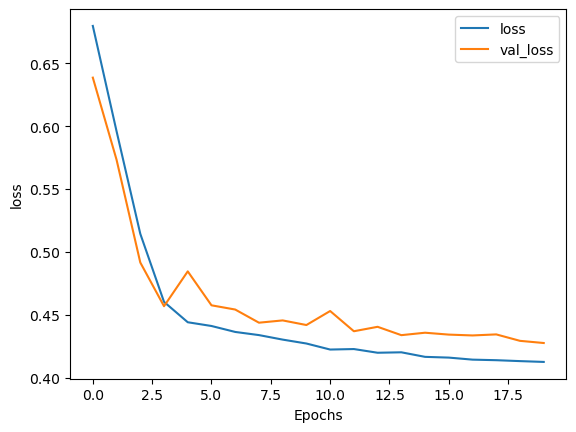

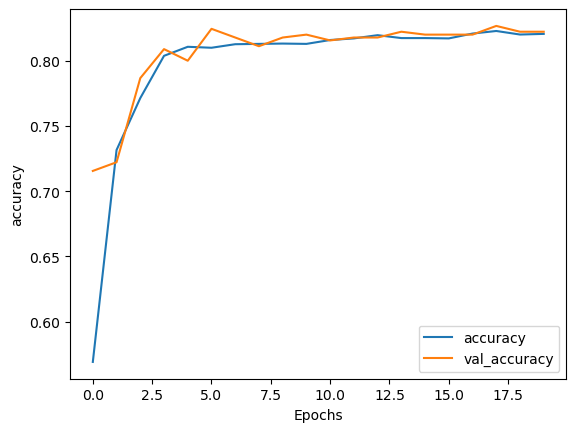

In [201]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
# plot_history(history, 'precision')
# plot_history(history, 'recall')


In [205]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the test data
# _, accuracy = model.evaluate(X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
# print(metrics)
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.6).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

y_test

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7581 - loss: 0.5983
Accuracy: 77.21
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Precision: 34.93
Recall: 46.79
F1-score: 40.00


array([0, 0, 0, ..., 0, 0, 0])

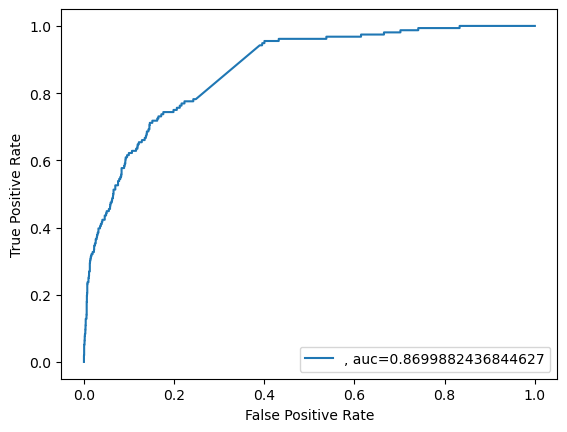

In [206]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label=", auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [93]:
# test_data.shape
# X_test.shape, len(test_data)
# import datetime
# x = pd.concat(test_data)
# y = []
# for i in range(1,len(hotspot_cells)):
#     y.append(x['hotspot'].iloc[24*i])

# # test_data[6]
# x[x.time_bin.dt.date == datetime.date(2017,3,1)].drop_duplicates()

In [209]:
import datetime
crime_hotspots = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.time_bin.dt.date >= datetime.date(2017, 3, 1) ]


crime_hotspots.loc[:,'predicted'] = y_pred_binary
# predicted_cell_ids = np.array(crime_hotspots[(crime_hotspots['predicted'] == 1) & (crime_hotspots.time_bin.dt.date == datetime.date(2017, 3, 1))]['unique_id'])
# actual_cell_ids = np.array(crime_hotspots[(crime_hotspots['hotspot'] == 1) & (crime_hotspots.time_bin.dt.date == datetime.date(2017, 3, 1)) ]['unique_id'])
# # real = crime_hotspots.hotspot
# # pred = crime_hotspots.predicted
# com = np.intersect1d(predicted_cell_ids, actual_cell_ids)

# test_hotspots_crime_counts_df
crime_hotspots['predicted'].sum()
y_pred_binary.sum()

/tmp/ipykernel_172663/4262149700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_hotspots.loc[:,'predicted'] = y_pred_binary


209

In [210]:
cell_size = 600
# ppd_grids_clipped = gpd.read_file(f"../Qgis/self-created-grid/{cell_size}/crime-forecast-grid.shp")
grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

In [ ]:
test_time_step_starting_dates = test_time_bins[-7:]
test_time_step_starting_dates
crime_hotspots_1st_week = crime_hotspots[crime_hotspots.time_bin.dt.date == test_time_step_starting_dates[0].date() ]
crime_hotspots_1st_week['predicted'].sum()
predicted_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].unique_id)
hotspot_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['hotspot'] == 1].unique_id)


total_crimes_in_predicted_hotspots = crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count.sum()


predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()

# # x

(0.0, 1381)

In [89]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
# maximum_obtainable_crimes_for_the_forecasted_area = 
# 
total_area, predicted_hotspots_area / (cell_size ** 2), pai
# pai


517.0
1381
118391944.8943044
4117743414.8055296


(4117743414.8055296, 328.86651359529, 13.020689747697114)

In [90]:

grid[grid.unique_id.isin(hotspot_grid_ids)]
desc_sorted = -np.sort(-np.array(crime_hotspots_1st_week.crime_count))

number_of_cells = int(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted[:number_of_cells].sum()

pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
pei

# grid['pre']
    
# # y_test
# test_crime_counts_df.crime_count.max()

1.0

In [91]:
len(predicted_grid_ids), len(hotspot_grid_ids), len(np.intersect1d(predicted_grid_ids, hotspot_grid_ids))

(330, 25, 25)

In [111]:
grid.loc[grid.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(hotspot_grid_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(predicted_grid_ids, hotspot_grid_ids)), 'hotspot'] = 3
grid.to_file(f"../Qgis/outputs/{cell_size}/crime-forecast-grid-new-26.shp")
grid


,unique_id,hotspot,x_index,y_index,area,geometry
0,1,0,0,98,126069.479649,"POLYGON ((7604013.056 710715.558, 7604604.588 ..."
1,2,0,0,99,347437.898186,"POLYGON ((7604037.994 711315.558, 7604604.588 ..."
2,3,0,0,100,332474.858733,"POLYGON ((7604062.933 711915.558, 7604604.588 ..."
3,4,0,0,101,317511.819280,"POLYGON ((7604087.871 712515.558, 7604604.588 ..."
4,5,0,0,102,302548.779827,"POLYGON ((7604112.809 713115.558, 7604604.588 ..."
...,...,...,...,...,...,...
11980,11981,0,160,81,259345.783629,"POLYGON ((7700604.588 700123.915, 7700604.588 ..."
11981,11982,0,160,82,2816.972293,"POLYGON ((7700090.578 700515.558, 7700004.588 ..."
11982,11983,0,161,80,173713.379556,"POLYGON ((7701204.588 699666.753, 7701204.588 ..."
11983,11984,0,161,81,28488.405276,"POLYGON ((7700878.046 699915.558, 7700604.588 ..."
